import libraries

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc


In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
results_file = 'write/2560248.h5ad'

read data into adata

In [4]:
adata = sc.read_10x_mtx(
    'data/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-matrix.h5ad


In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 14619 × 35635
    var: 'gene_ids'

### Preprocessing

show genes that yield highest fraction of counts in each single cells, across all cells

normalizing counts per cell
    finished (0:00:00)


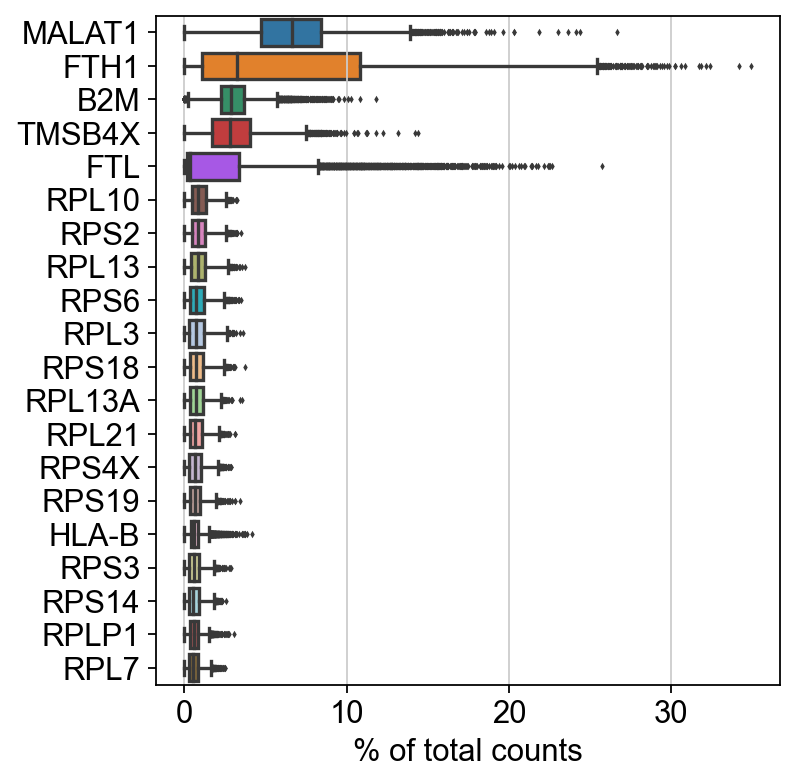

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )

basic filtering

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 93 cells that have less than 200 genes expressed
filtered out 20712 genes that are detected in less than 3 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 14526 × 14923
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

calculate qc matrix

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

In [11]:
adata.var_names

Index(['AL627309.1', 'RP11-206L10.2', 'RP11-206L10.9', 'FAM87B', 'LINC00115',
       'FAM41C', 'NOC2L', 'KLHL17', 'PLEKHN1', 'HES4',
       ...
       'LSS', 'MCM3AP-AS1', 'MCM3AP', 'AP001469.9', 'YBEY', 'C21orf58', 'PCNT',
       'DIP2A', 'S100B', 'PRMT2'],
      dtype='object', length=14923)

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

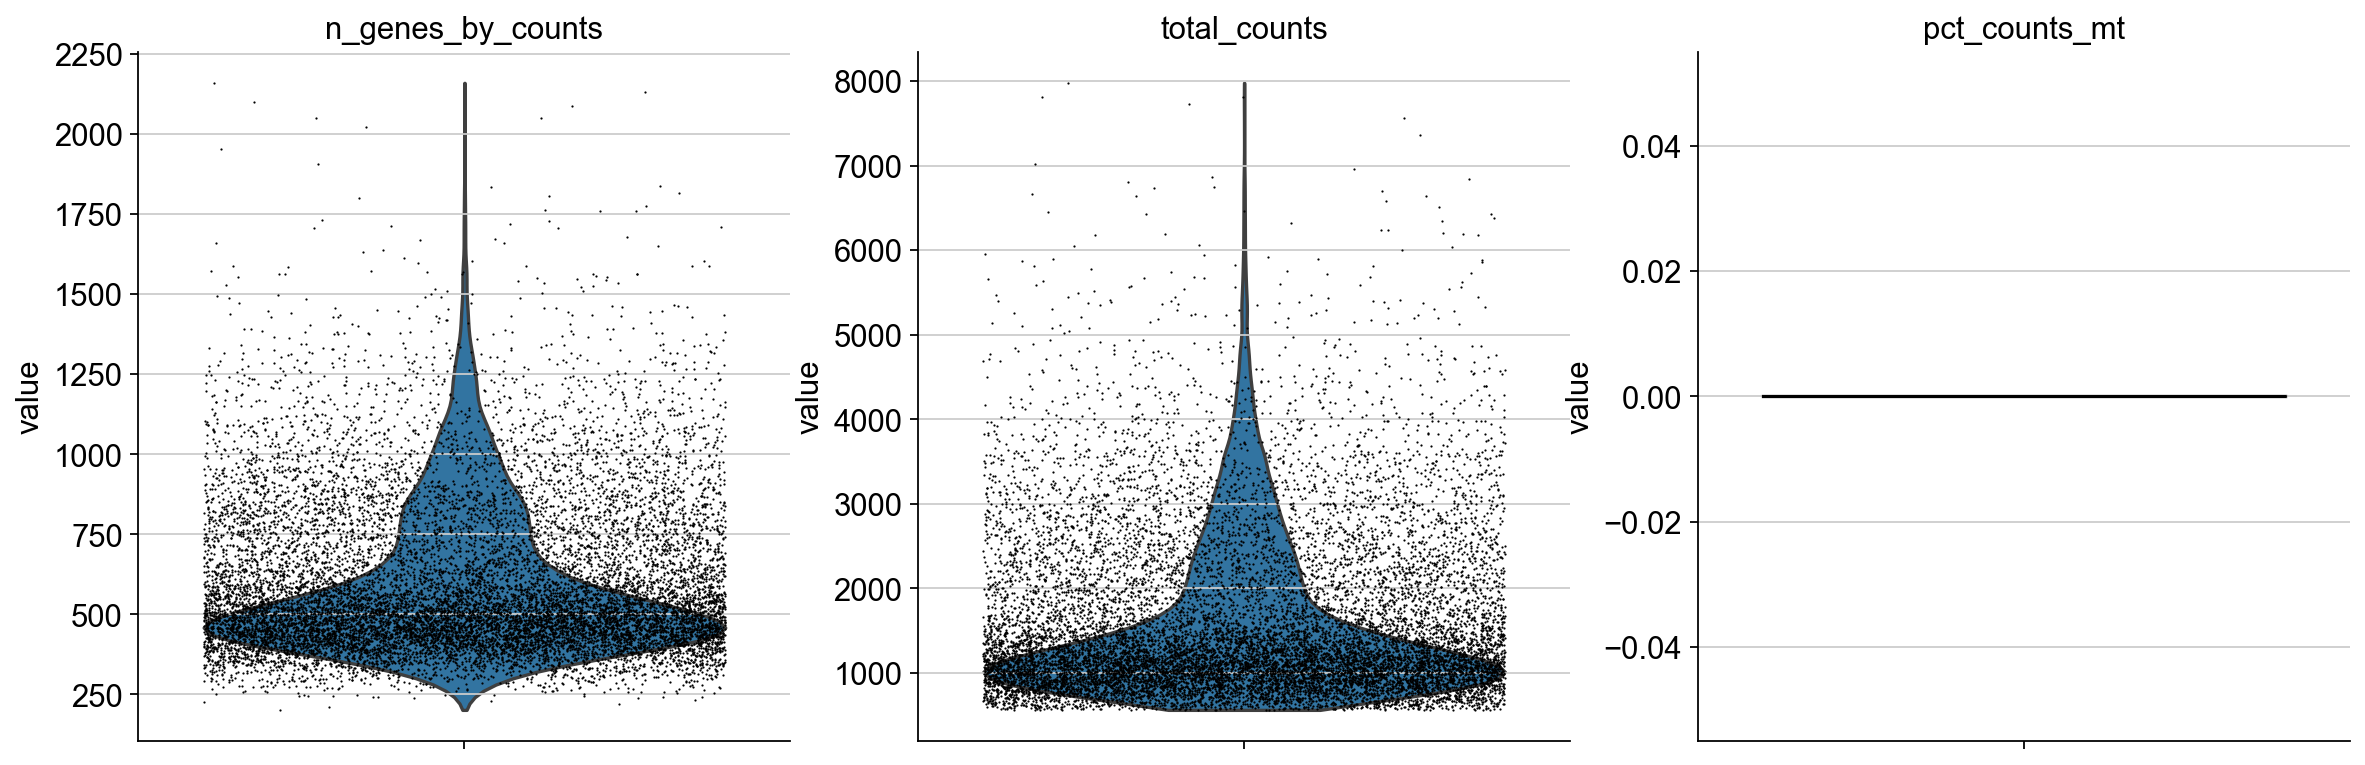

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

show mitochondrial genes/n_genes_by_counts

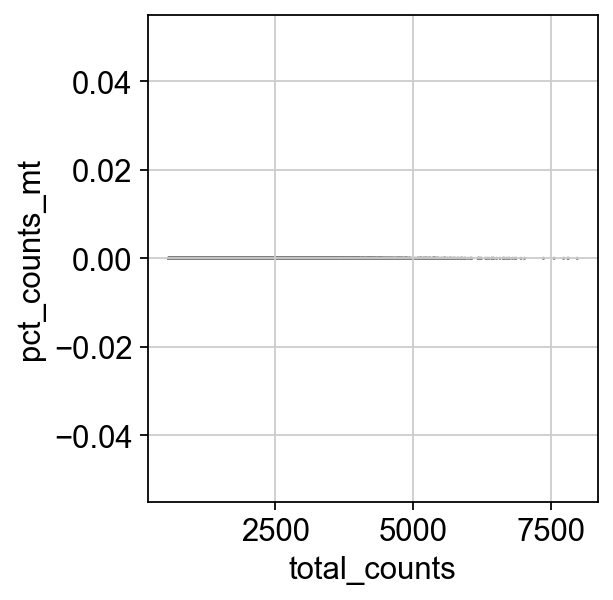

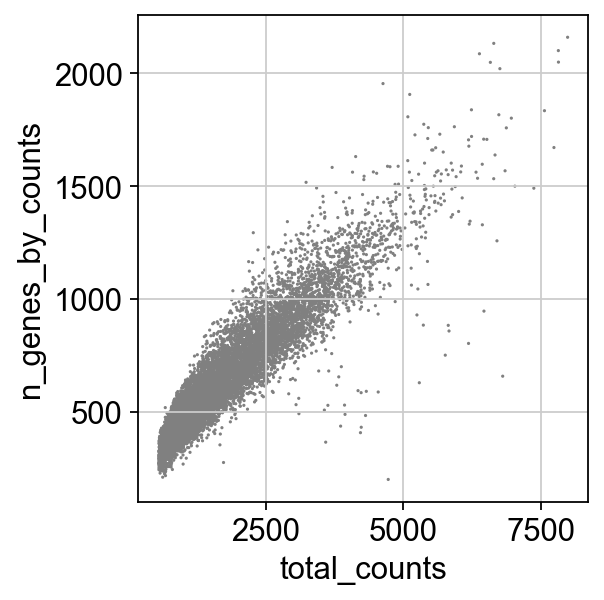

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

remove cells with too many total counts (no mitochodrial gene reads)

In [14]:
adata = adata[adata.obs.n_genes_by_counts < 1800, :]

In [15]:
adata

View of AnnData object with n_obs × n_vars = 14512 × 14923
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


    finished (0:00:00)


/Users/qiaojiamu/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


logarithmize data

In [17]:
sc.pp.log1p(adata)

In [18]:
adata

AnnData object with n_obs × n_vars = 14512 × 14923
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'

Identify highly-variable genes

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


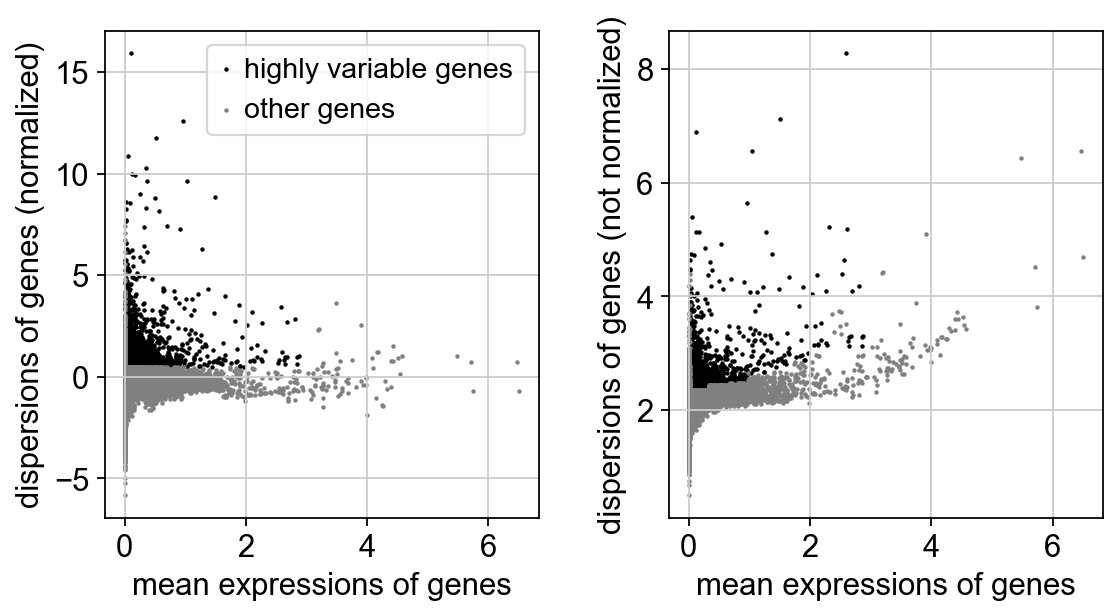

In [20]:
sc.pl.highly_variable_genes(adata)

save data

In [21]:
adata.raw = adata

do filtering

In [22]:
adata = adata[:, adata.var.highly_variable]

In [23]:
adata

View of AnnData object with n_obs × n_vars = 14512 × 2080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [24]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:48)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [25]:
sc.pp.scale(adata, max_value=10)

In [26]:
adata

AnnData object with n_obs × n_vars = 14512 × 2080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## PCA

run PCA

In [27]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


scatter plot in the PCA coordinates

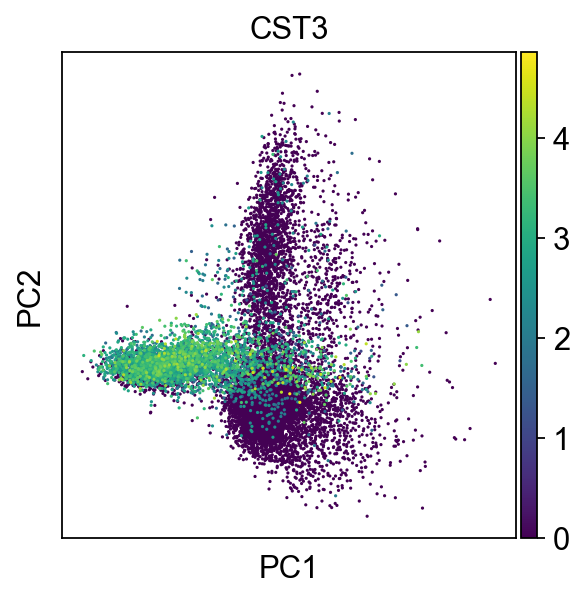

In [28]:
sc.pl.pca(adata, color='CST3')

PC / variance ratio plot

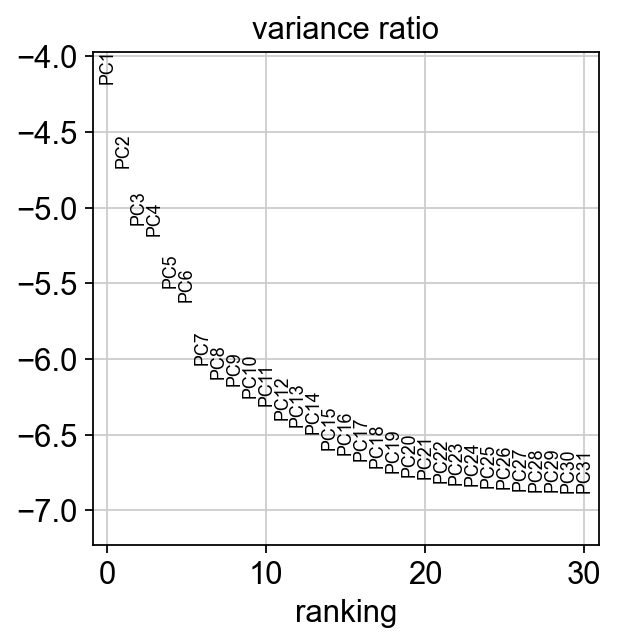

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

save the results

In [30]:
adata.write(results_file)

In [31]:
adata

AnnData object with n_obs × n_vars = 14512 × 2080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Compute the neighborhood graph

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40


/Users/qiaojiamu/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/qiaojiamu/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/qiaojiamu/opt/anaconda3/envs/scanpy/lib/python3.8

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


## Embed the neighborhood graph

In [33]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


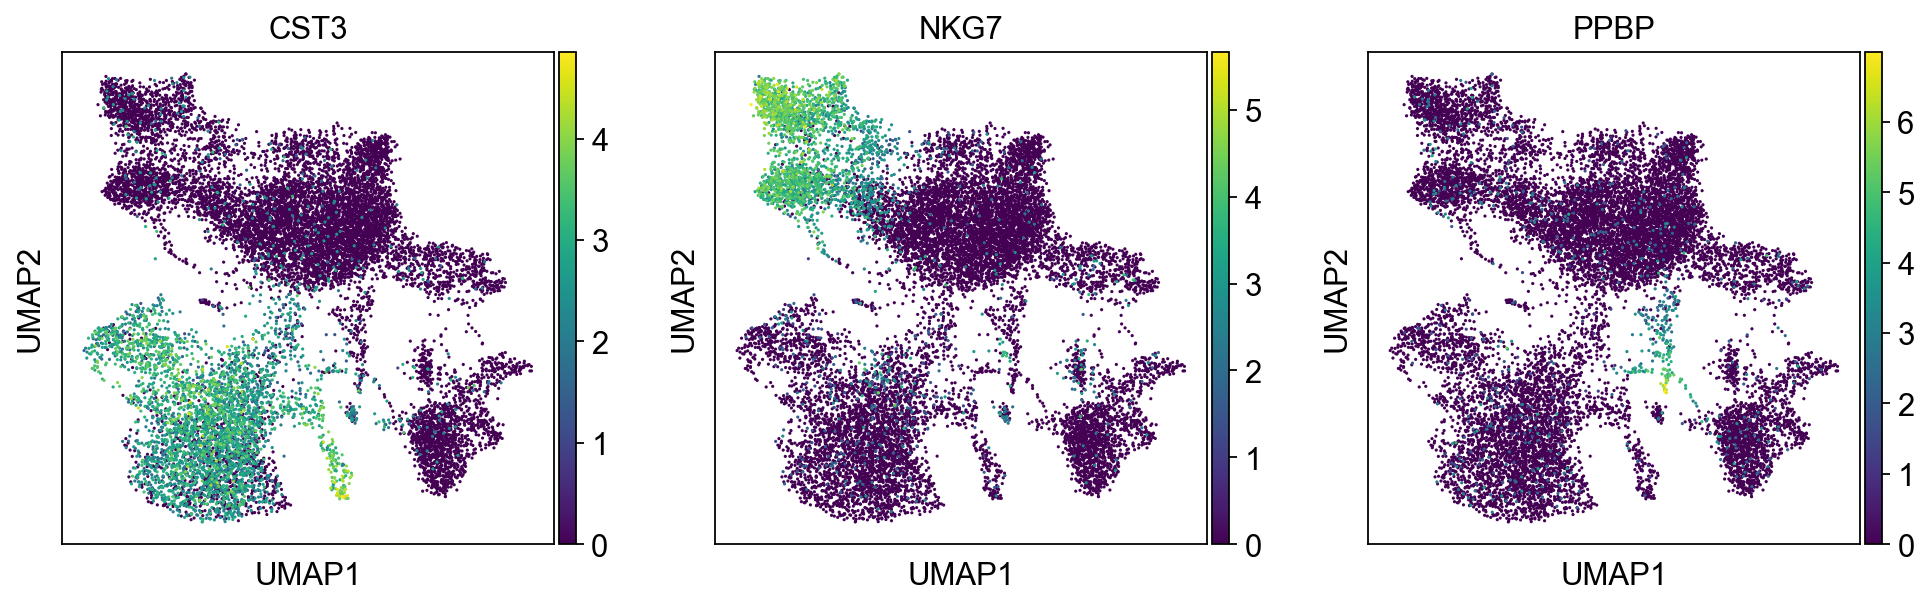

In [34]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

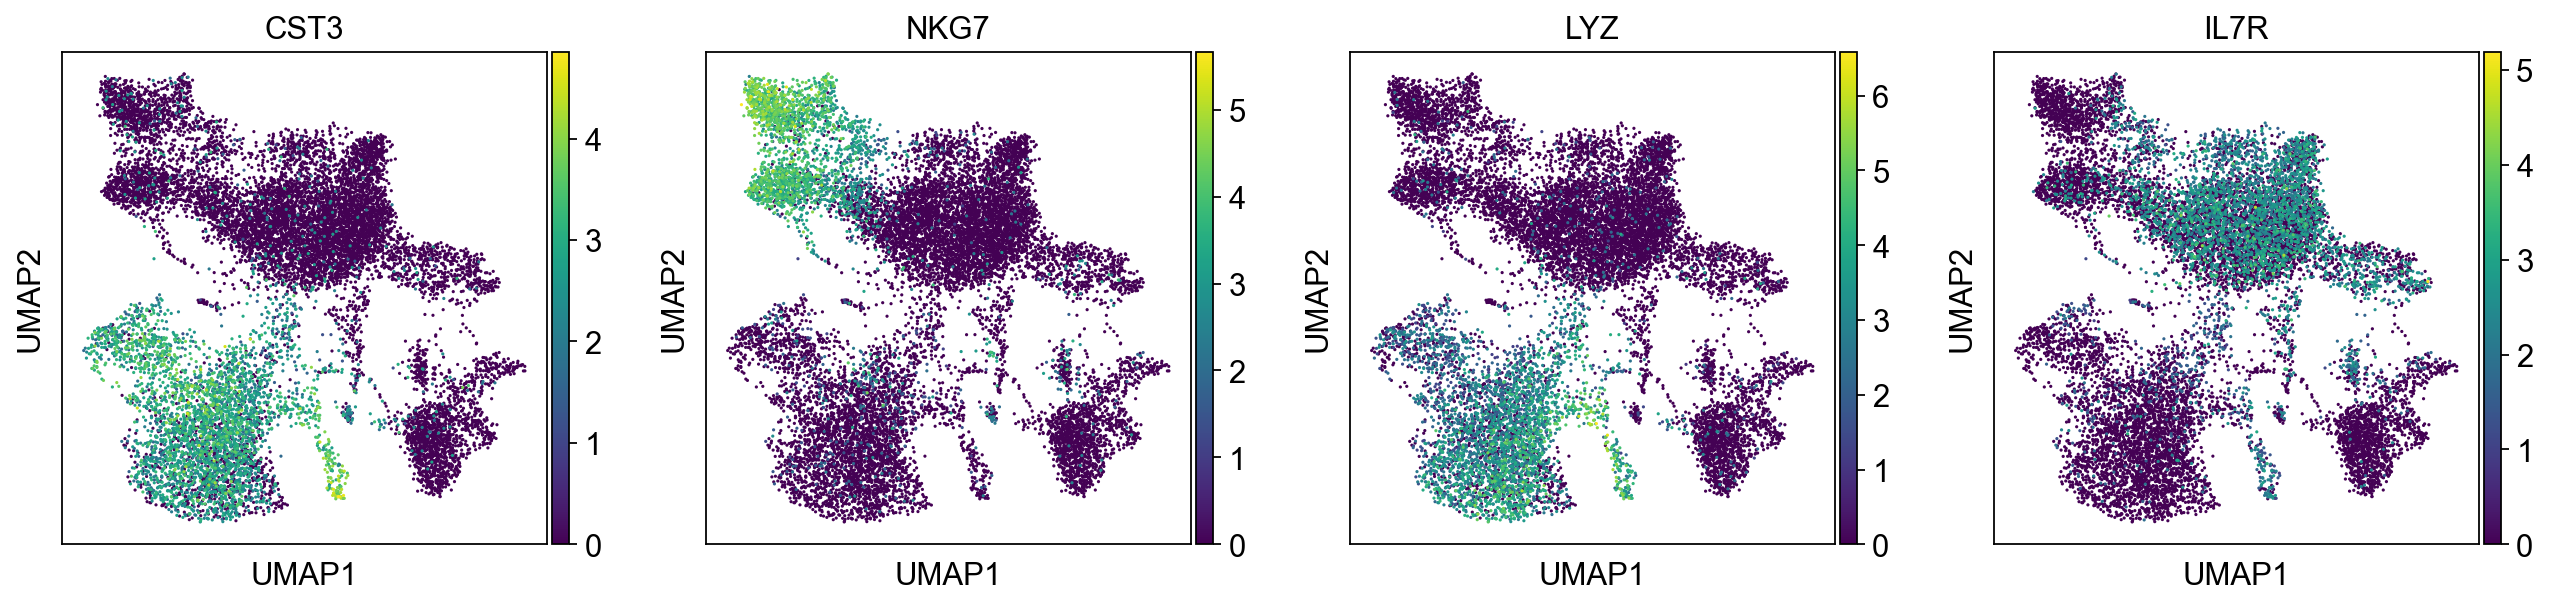

In [39]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'LYZ', 'IL7R'], use_raw=True)

## Clustering the neighborhood graph using leiden algorithm

In [ ]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


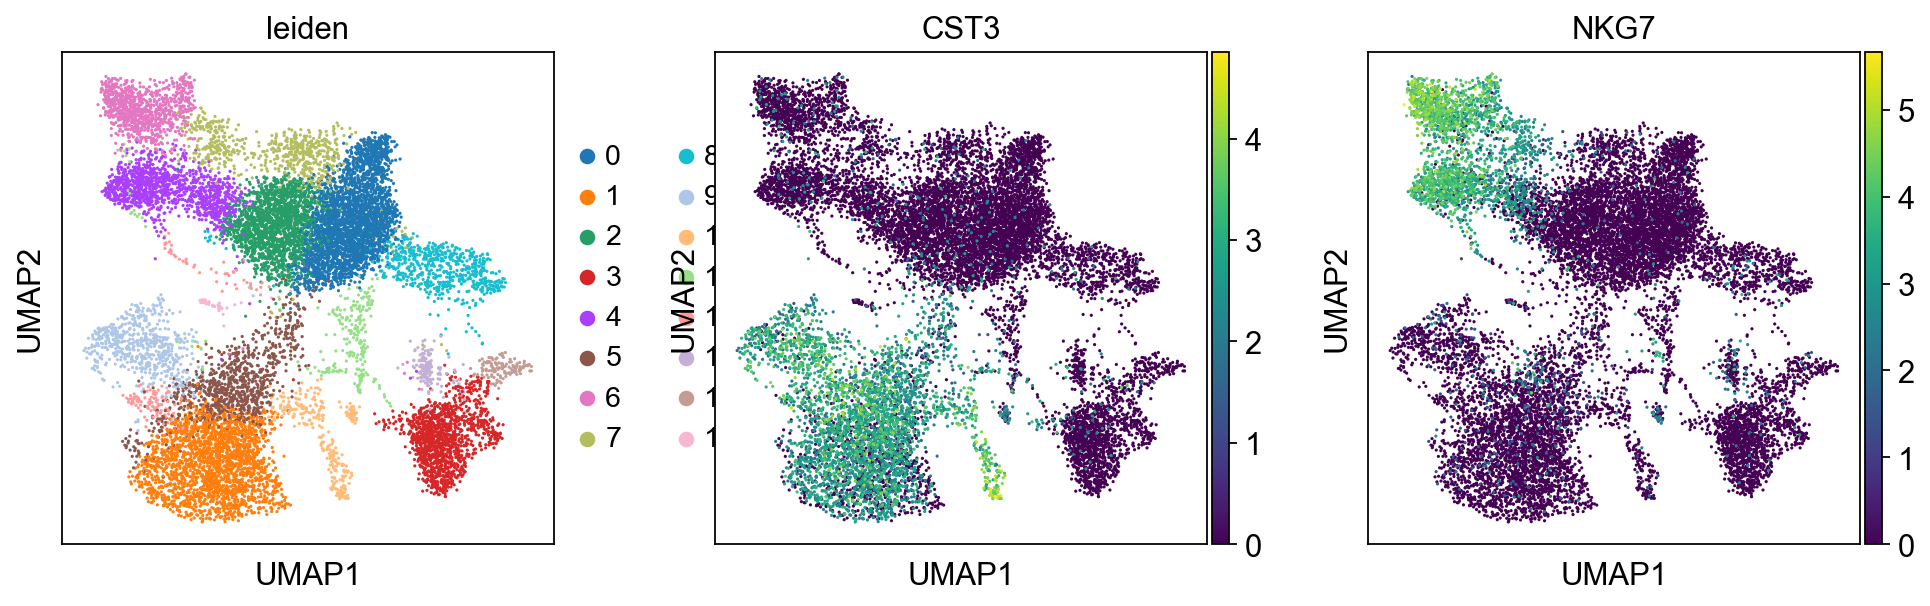

In [ ]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

save the results

In [ ]:
adata.write(results_file)

## Finding marker genes

compute the ranking for the highly differential genes in each cluster using t-test

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


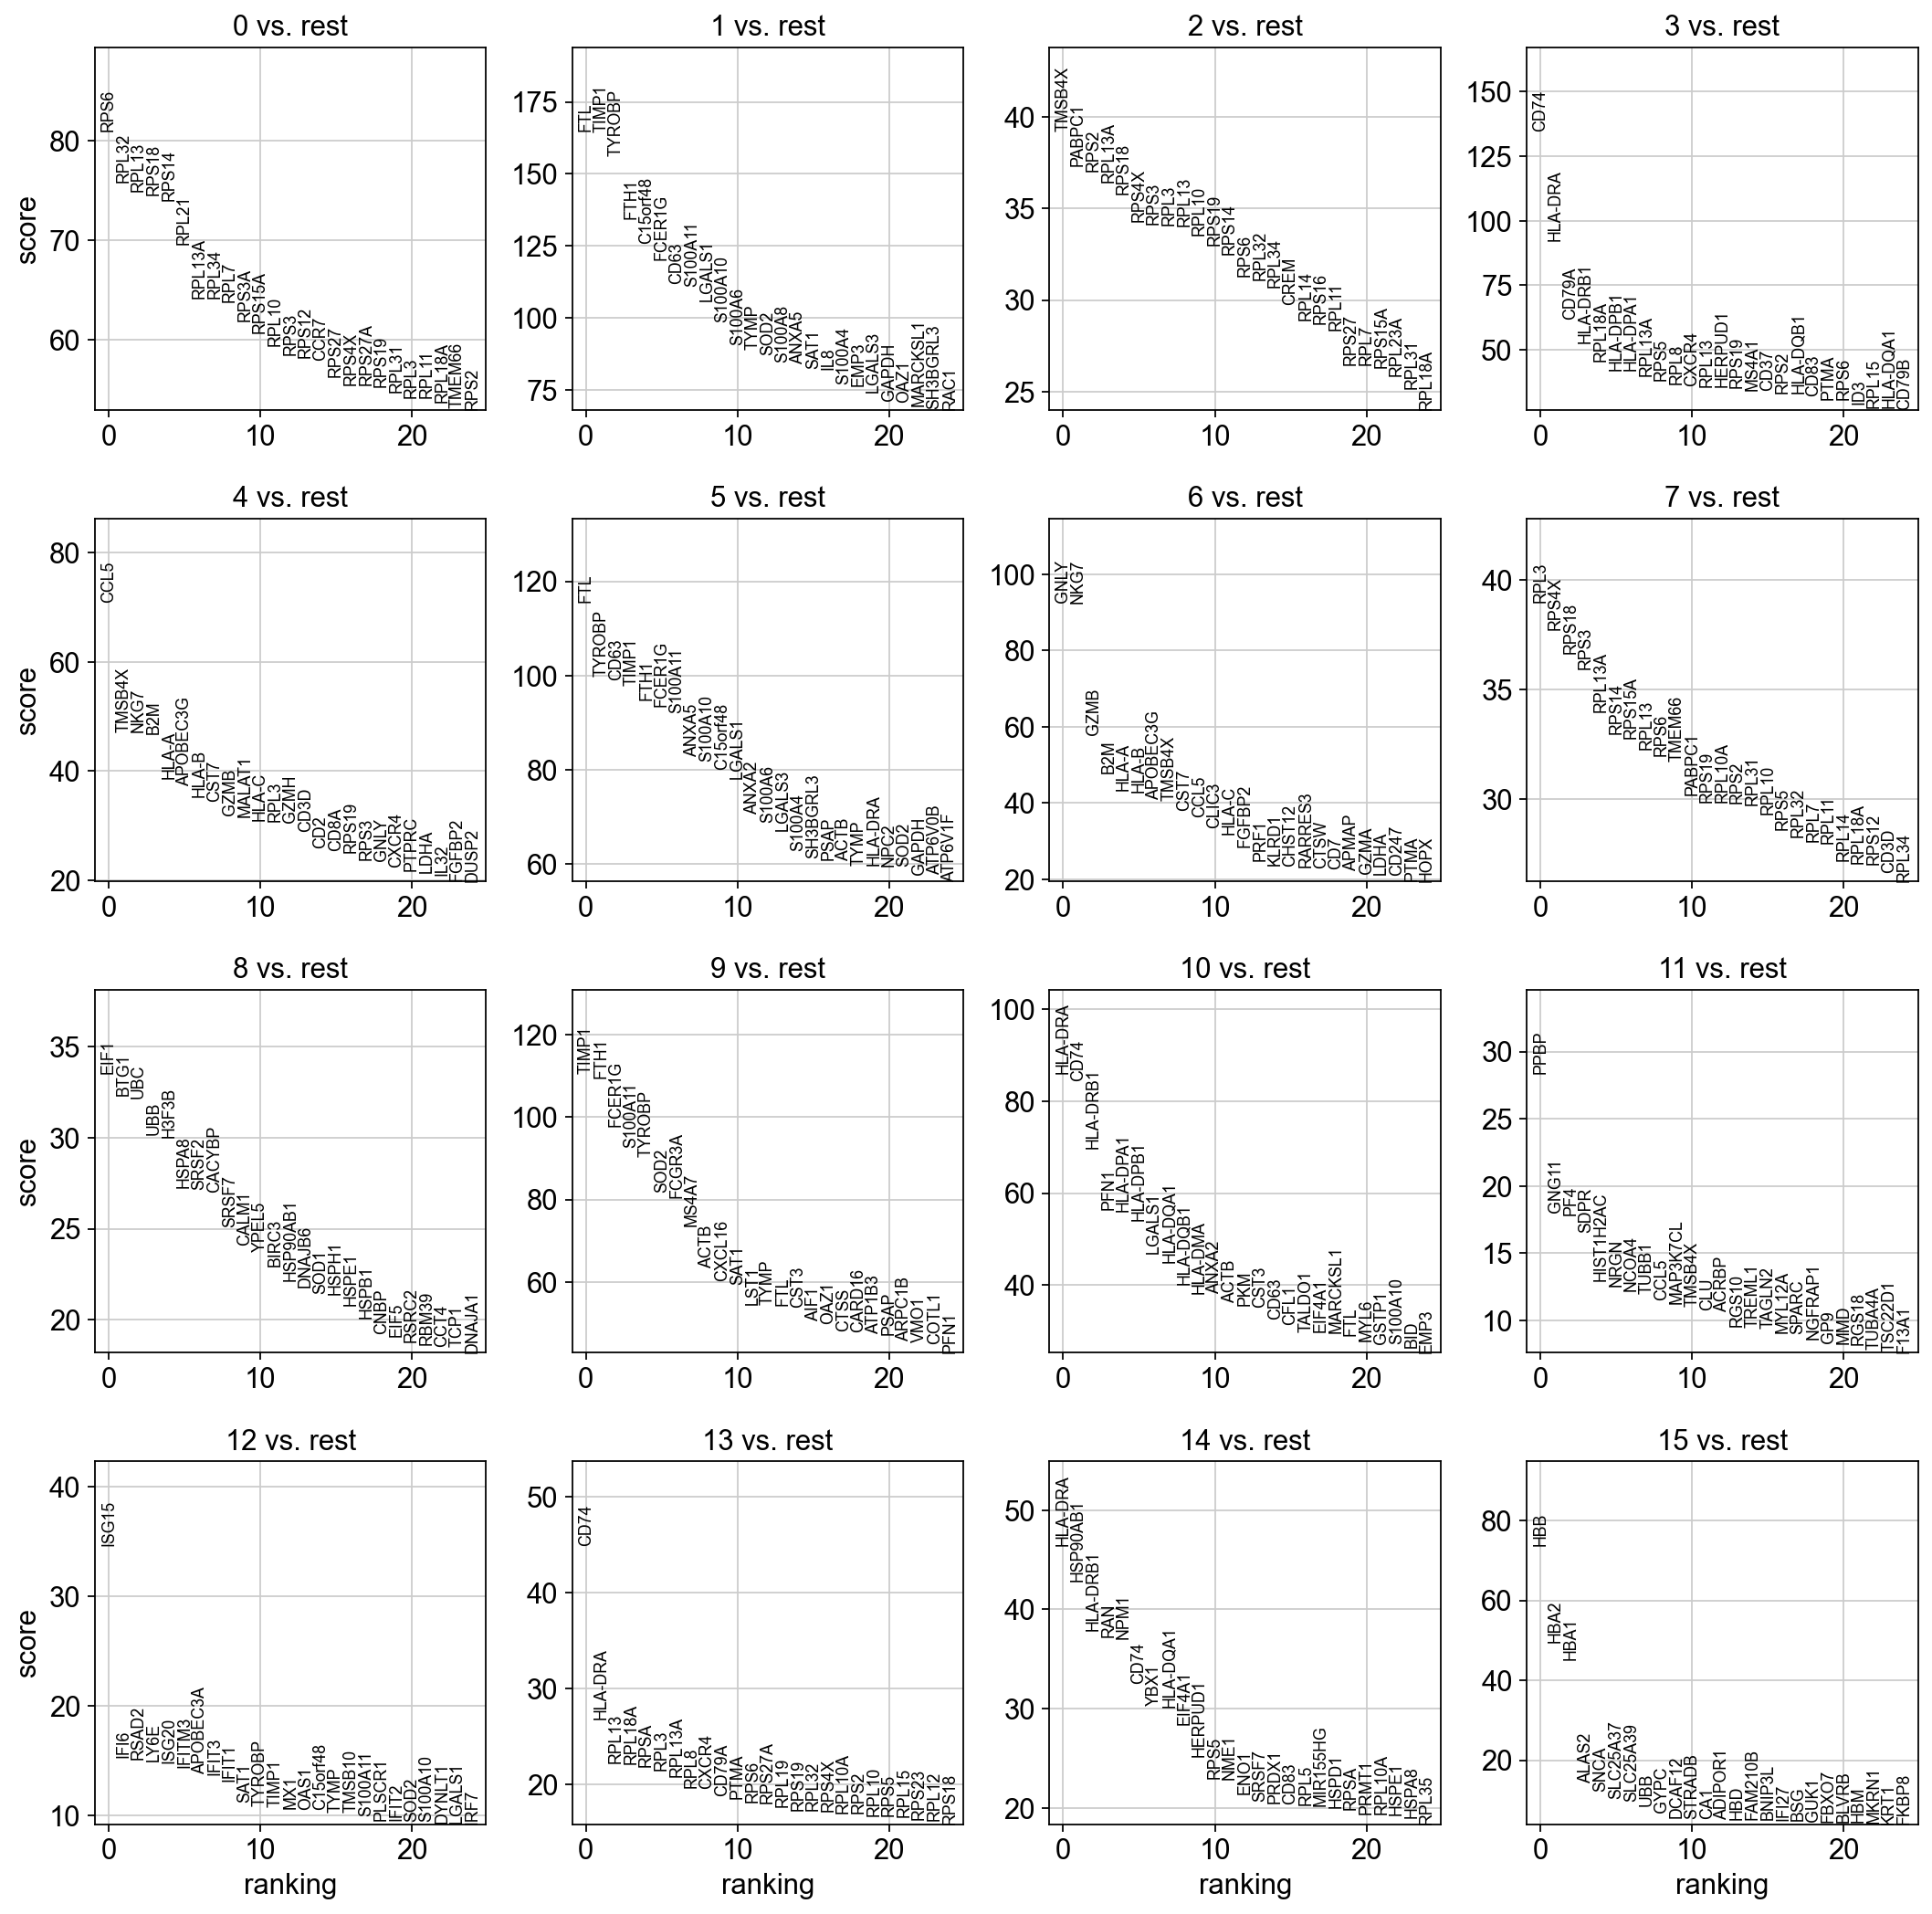

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

use Wilcoxon rank-sum

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:10)


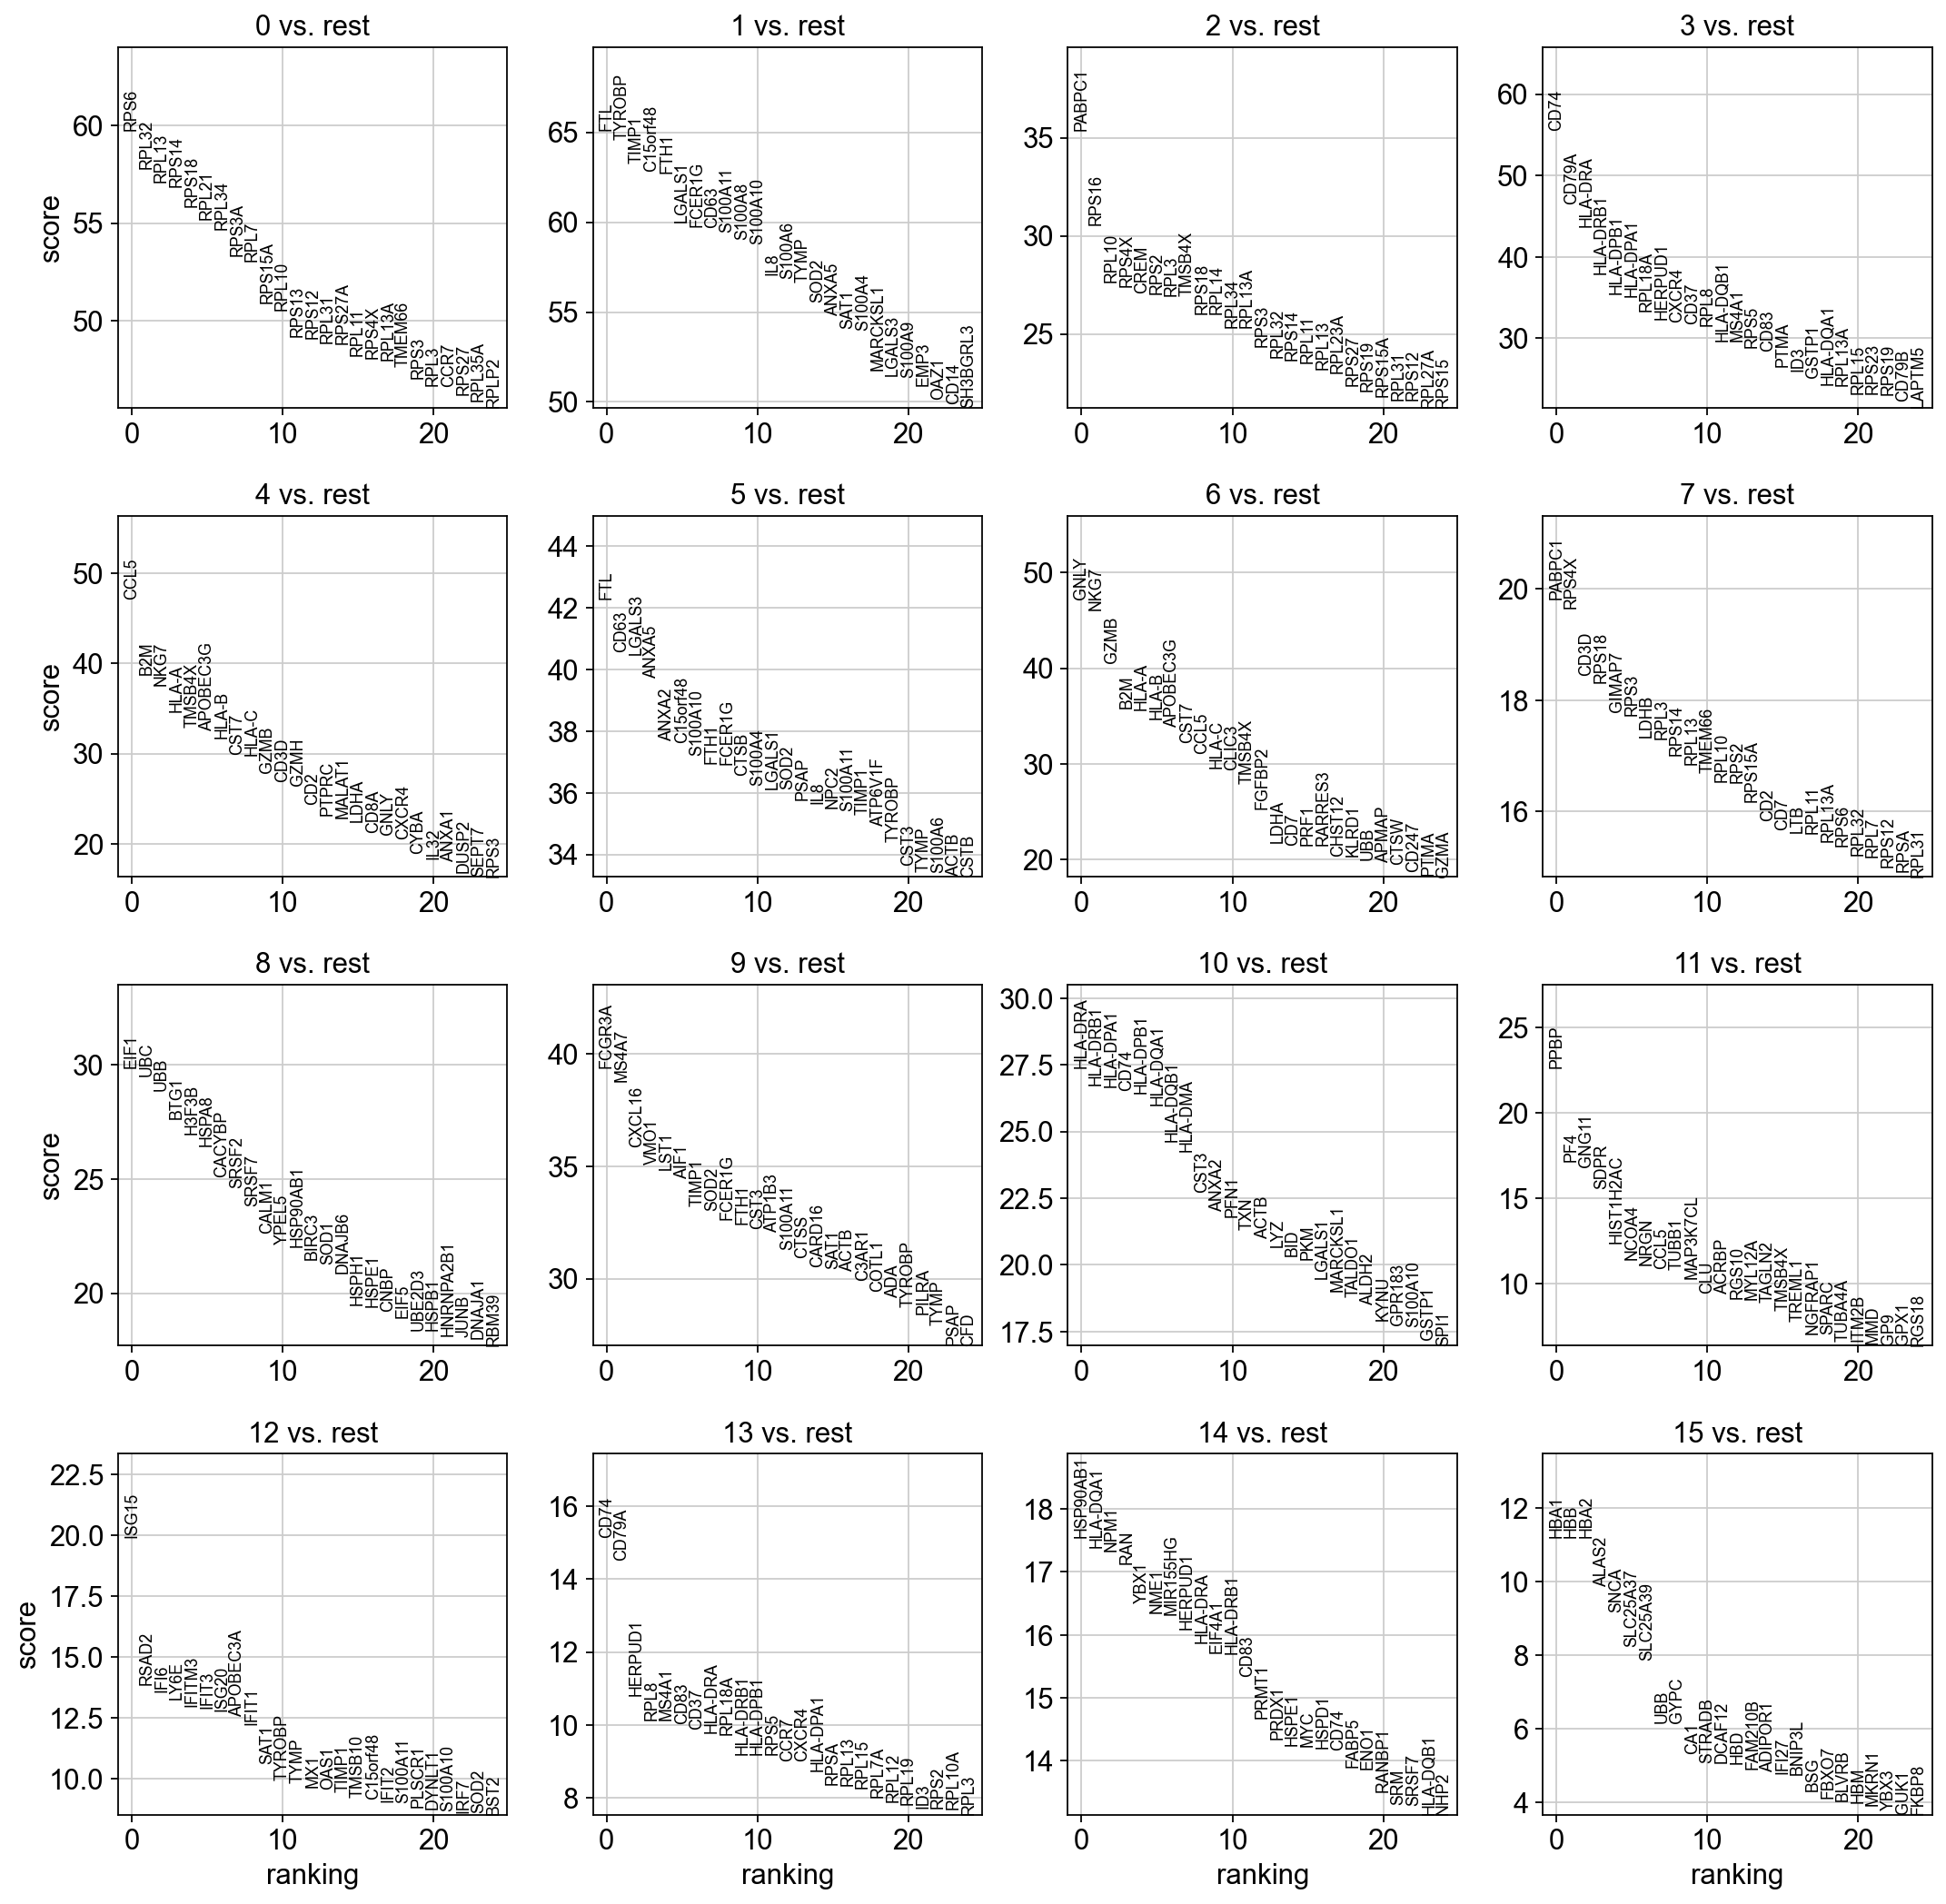

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

use logistic regression, multi-variate approach

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:14)


/Users/qiaojiamu/opt/anaconda3/envs/scanpy/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


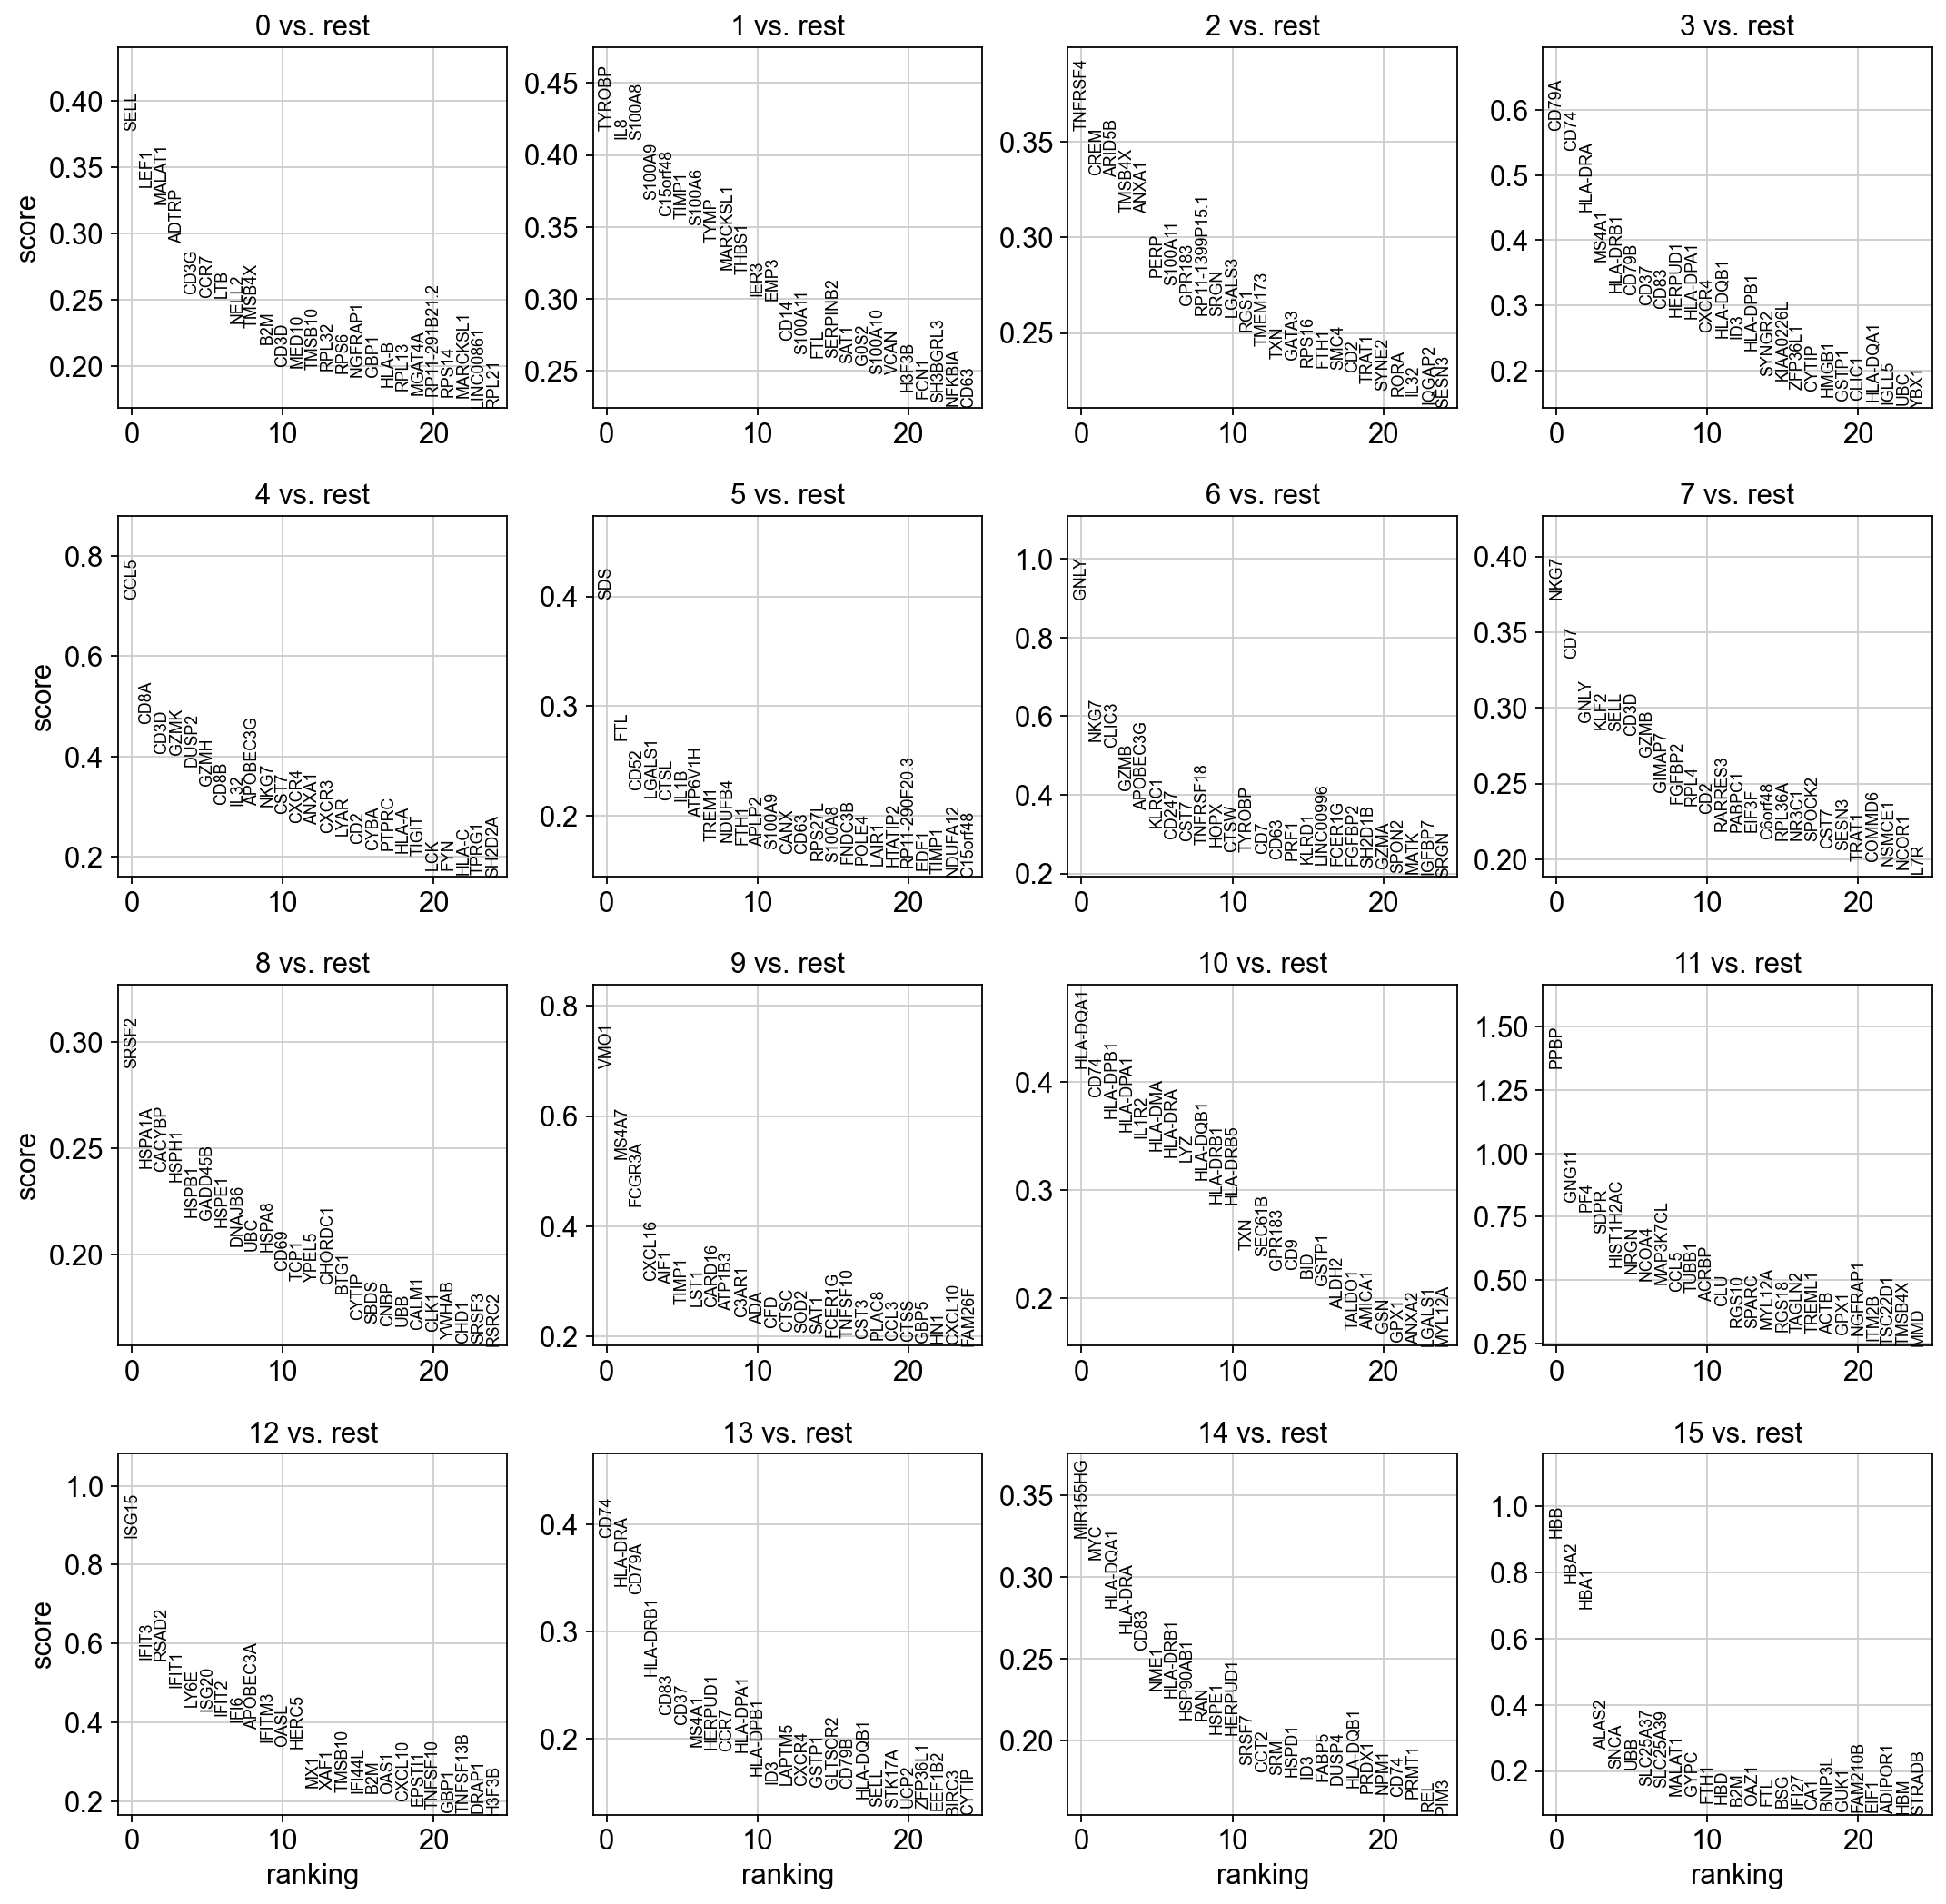

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [ ]:
adata = sc.read(results_file)

show top-ranked genes in each cluster

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0         1       2         3       4       5      6       7      8  \
0   RPS6       FTL  PABPC1      CD74    CCL5     FTL   GNLY  PABPC1   EIF1   
1  RPL32    TYROBP   RPS16     CD79A     B2M    CD63   NKG7   RPS4X    UBC   
2  RPL13     TIMP1   RPL10   HLA-DRA    NKG7  LGALS3   GZMB    CD3D    UBB   
3  RPS14  C15orf48   RPS4X  HLA-DRB1   HLA-A   ANXA5    B2M   RPS18   BTG1   
4  RPS18      FTH1    CREM  HLA-DPB1  TMSB4X   ANXA2  HLA-A  GIMAP7  H3F3B   

        9        10         11      12       13        14     15  
0  FCGR3A   HLA-DRA       PPBP   ISG15     CD74  HSP90AB1   HBA1  
1   MS4A7  HLA-DRB1        PF4   RSAD2    CD79A  HLA-DQA1    HBB  
2  CXCL16  HLA-DPA1      GNG11    IFI6  HERPUD1      NPM1   HBA2  
3    VMO1      CD74       SDPR    LY6E     RPL8       RAN  ALAS2  
4    LST1  HLA-DPB1  HIST1H2AC  IFITM3    MS4A1      YBX1   SNCA

create a table with scores and groups

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n  0_p       1_n  1_p     2_n            2_p       3_n            3_p  \
0   RPS6  0.0       FTL  0.0  PABPC1  4.743976e-274      CD74   0.000000e+00   
1  RPL32  0.0    TYROBP  0.0   RPS16  4.439338e-205     CD79A   0.000000e+00   
2  RPL13  0.0     TIMP1  0.0   RPL10  3.277180e-168   HLA-DRA   0.000000e+00   
3  RPS14  0.0  C15orf48  0.0   RPS4X  1.388214e-165  HLA-DRB1   0.000000e+00   
4  RPS18  0.0      FTH1  0.0    CREM  2.215223e-161  HLA-DPB1  1.401175e-274   

      4_n            4_p  ...       11_n           11_p    12_n          12_p  \
0    CCL5   0.000000e+00  ...       PPBP  4.109548e-113   ISG15  2.945216e-88   
1     B2M   0.000000e+00  ...        PF4   6.498826e-66   RSAD2  1.154530e-43   
2    NKG7  4.816371e-308  ...      GNG11   1.272207e-63    IFI6  7.007705e-42   
3   HLA-A  3.649496e-262  ...       SDPR   2.434779e-54    LY6E  4.759920e-40   
4  TMSB4X  9.763227e-238  ...  HIST1H2AC   3.735609e-35  IFITM3  1.629857e-38   

      13_n          13_p      14_n          14_p   15_n          15_p  
0     CD74  6.991540e-52  HSP90AB1  5.791884e-69   HBA1  3.723652e-29  
1    CD79A  1.089183e-47  HLA-DQA1  9.460146e-68    HBB  3.729863e-29  
2  HERPUD1  3.804792e-27      NPM1  2.771815e-67   HBA2  3.911264e-29  
3     RPL8  3.886651e-24       RAN  9.292390e-66  ALAS2  5.466476e-23  
4    MS4A1  4.609527e-24      YBX1  3.369656e-61   SNCA  4.711842e-20  

[5 rows x 32 columns]

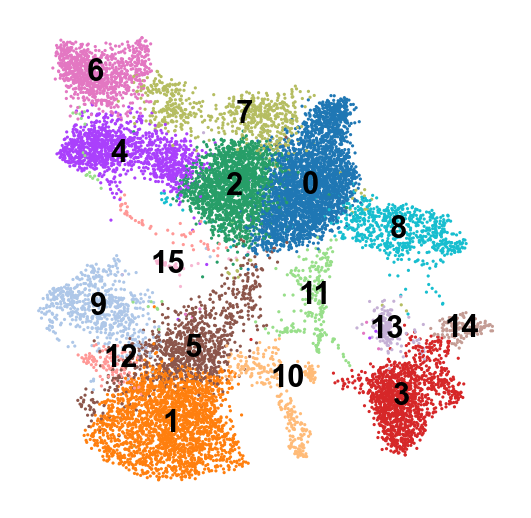

In [ ]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [ ]:
adata

AnnData object with n_obs × n_vars = 14512 × 2080
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

save

In [ ]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

read the author's cell types

In [ ]:
df_cell_types = pd.read_csv('data/GSE96583_batch2.total.tsne.df.tsv', sep='\t')

In [ ]:
df_cell_types

tsne1      tsne2   ind  stim  cluster             cell  \
AAACATACAATGCC-1  -4.277833 -19.294709   107  ctrl        5      CD4 T cells   
AAACATACATTTCC-1 -27.640373  14.966629  1016  ctrl        9  CD14+ Monocytes   
AAACATACCAGAAA-1 -27.493646  28.924885  1256  ctrl        9  CD14+ Monocytes   
AAACATACCAGCTA-1 -28.132584  24.925484  1256  ctrl        9  CD14+ Monocytes   
AAACATACCATGCA-1 -10.468194  -5.984389  1488  ctrl        3      CD4 T cells   
...                     ...        ...   ...   ...      ...              ...   
TTTGCATGCTAAGC-1  25.142392   6.603815   107  stim        6      CD4 T cells   
TTTGCATGGGACGA-1  14.359657  10.965601  1488  stim        6      CD4 T cells   
TTTGCATGGTGAGG-1  27.317997   7.933458  1488  stim        6      CD4 T cells   
TTTGCATGGTTTGG-1  13.744084   9.347784  1244  stim        6      CD4 T cells   
TTTGCATGTCTTAC-1  14.572118  -4.713942  1016  stim        5      CD4 T cells   

                 multiplets  
AAACATACAATGCC-1    doublet  
AAACATACATTTCC-1    singlet  
AAACATACCAGAAA-1    singlet  
AAACATACCAGCTA-1    doublet  
AAACATACCATGCA-1    singlet  
...                     ...  
TTTGCATGCTAAGC-1    singlet  
TTTGCATGGGACGA-1    singlet  
TTTGCATGGTGAGG-1       ambs  
TTTGCATGGTTTGG-1       ambs  
TTTGCATGTCTTAC-1    singlet  

[29065 rows x 7 columns]

In [ ]:
cell_types_pred = adata.obs['leiden'].astype(int)

In [ ]:
cell_types_pred

AAACATACAATGCC-1    7
AAACATACATTTCC-1    5
AAACATACCAGAAA-1    5
AAACATACCAGCTA-1    5
AAACATACCATGCA-1    8
                   ..
TTTGCATGCTTCGC-1    3
TTTGCATGGCAGTT-1    1
TTTGCATGGGAACG-1    4
TTTGCATGGTCCTC-1    3
TTTGCATGTTCATC-1    2
Name: leiden, Length: 14512, dtype: int64

In [ ]:
cell_types_auther = df_cell_types.loc[df_cell_types.index.isin(cell_types_pred.index)]

In [ ]:
cell_types_auther = cell_types_auther['cluster']

In [ ]:
cell_types_auther

AAACATACAATGCC-1     5
AAACATACATTTCC-1     9
AAACATACCAGAAA-1     9
AAACATACCAGCTA-1     9
AAACATACCATGCA-1     3
                    ..
TTTGCATGCTTCGC-1     4
TTTGCATGGCAGTT-1     9
TTTGCATGGGAACG-1    10
TTTGCATGGTCCTC-1     4
TTTGCATGTTCATC-1     5
Name: cluster, Length: 14512, dtype: int64

confusion matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

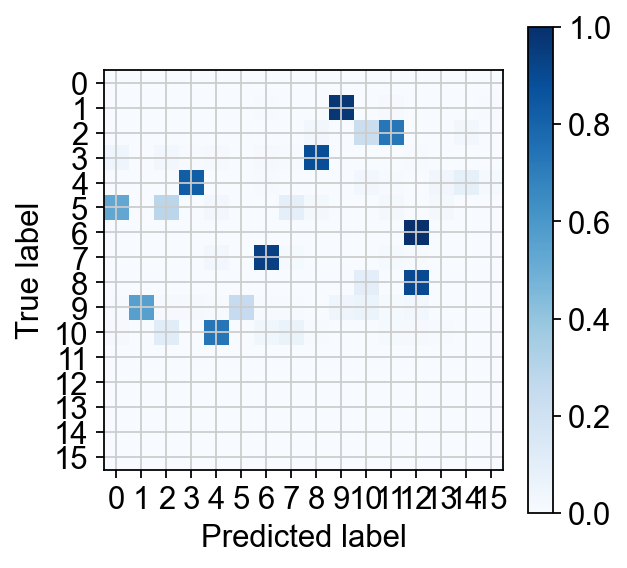

In [ ]:
ConfusionMatrixDisplay.from_predictions(cell_types_auther, cell_types_pred, normalize='true', include_values=False, cmap=plt.cm.Blues)

align labels to the auther's labels for better visualization

In [ ]:
cell_types_pred = adata.obs['leiden'].astype(int)

In [ ]:
#6 -> 7 -> 107
#3 -> 4 -> 10 -> 100
#0 -> 5 -> 105
#1 <-> 9
cell_types_pred.replace([7, 10, 5, 9], [107, 100, 105, 109], inplace=True)
cell_types_pred.replace([6, 4, 0, 1], [7, 10, 5, 9], inplace=True)
cell_types_pred.replace([3, 109], [4, 1], inplace=True)

In [ ]:
#8 -> 3
#11 -> 2 -> 102
#12 -> 6
cell_types_pred.replace(2, 102, inplace=True)
cell_types_pred.replace([8, 11, 12], [3, 2, 6], inplace=True)

In [ ]:
#107 -> 11
#100 -> 12
#105 -> 0
#102 -> 8 
cell_types_pred.replace([107, 100, 105, 102], [11, 12, 0, 8], inplace=True)

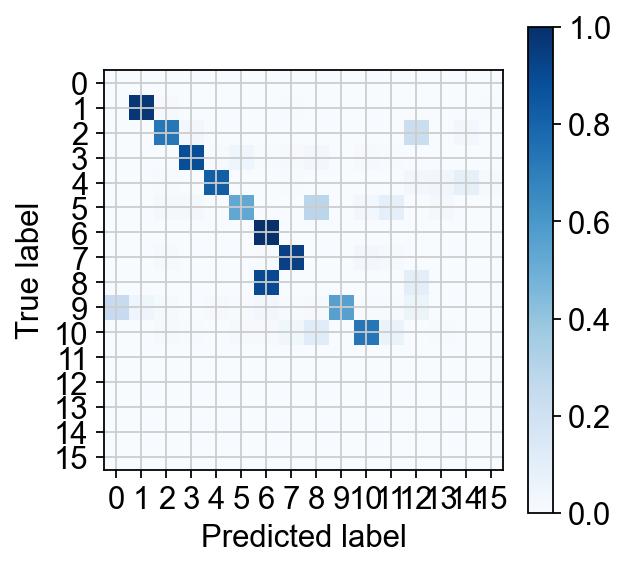

In [ ]:
ConfusionMatrixDisplay.from_predictions(cell_types_auther, cell_types_pred, normalize='true', include_values=False, cmap=plt.cm.Blues)